# Data Wrangling Final Project: Purple Air

Greg Lee
<br>u0890227
<br>04.24.20

**Summary**
Utah is home to "the greatest snow on earth". When it isn't snowing though, the Wasatch basin becomes a magnet for air pollution through an inverted air column. This atmospheric inversion keeps pollutants in proximal toxicity to the population. Particulate matter 2.5 is known to be hazardous to humans and has been associated with increased cardiovascular and cancer risk. The study of particulate matter within the Salt Lake basin is important to ensuring the population and government is able to mitigate exposure. 

Herein, an analysis is performed on collected Purpleair and Airnow PM2.5 exposures over the week of April 7th-14th. Comparison is made between 2019 and 2020 alongside the differences between Purpleair and Airnow accuracy.

**Table of Contents:**
1. Data Collection
2. Descriptive Analysis
3. Cleaning the Data
4. Filling null values
5. PM2.5 Analysis and Visualization
6. Prediction
7. Summary and Conclusion

## Data Collection:

In [1]:
#Libaries
#Use the lab_basic venv

#Basics:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist
import os
import seaborn as sns
from scipy import stats
import math

#Scraping:
import requests
import json
from urllib.request import urlopen,urlretrieve
import sys
from datetime import datetime
import pytz

#Dates
from datetime import datetime
import datetime as dt

#Prediction
from fbprophet import Prophet
import statsmodels.formula.api as smf
import statsmodels.api as sm

#Geography
import geopandas as gpd
import fiona
from shapely.geometry import Point
import descartes
import contextily as ctx #Basemaps 

Importing plotly failed. Interactive plots will not work.


# Collect Data

### PurpleAir Data

Data collection for purpleair data is being run through their json querry and an airflow scheduling assistant. Essentially, purpleair only posts realtime data from their sensors to the web at an unknown refresh rate. There is no way to querry data from the past. Instead, one must manually collect scrape the data at some frequency for analysis.

To this end, I've put together an airflow DAG to collect this data, arange it into a pandas dataframe and pickle it for further use. This data would be best put into a SQL database. To ensure this project maintained a manageabler workload, I decided to take on only one new technology (airflow). Further down the road, I would like to create automate the datastream into a database to minimize footprint. 

To see the DAG file, please look at the .py file contained within this folder. 

All data is saved as either legacy/experimental _MONTH_DAY_HOUR_MIN .pkl

# Getting the Data

### EPA Airnow

EPA Airnow is realtime collection of PM2.5 from across the country. There exists an API for data collection. For comparison we will load the 2019 data from April 7th to 14th. For quality control we will load the 2020 data from April 2020. All measurments will be for a bounding box surrounding Utah. 
<br>Source: https://docs.airnowapi.org/Data/docs#sampleUsage

In [8]:
#Run this script to query the Airnow data adjusting to the parameters as necessary
def main():
    # API parameters
    options = {}
    options["url"] = "https://www.airnowapi.org/aq/data/"
    options["start_date"] = "2019-04-07"
    options["start_hour_utc"] = "11"
    options['end_date'] = '2019-04-14' #This for all the data through 11 in MST
    options['end_hour_utc'] = "11"
    options["parameters"] = "OZONE,PM25,PM10"
    options["bbox"] = "-113.989989,37.043937,-108.936278,41.989859" #minx,miny,maxx,maxy for state of utah (includes wyoming corner)
    options["data_type"] = "B"
    options["format"] = "text/csv"
    options["api_key"] = "0ABAAB64-E208-4B1A-B6D7-735E98877CE0"

    # API request URL
    REQUEST_URL = options["url"] \
                  + "?startDate=" + options["start_date"] \
                  + "T"+options['start_hour_utc']\
                  + "&endDate=" + options["end_date"] \
                  + "T"+options['end_hour_utc']\
                  + "&parameters=" + options["parameters"] \
                  + "&BBOX=" + options["bbox"] \
                  + "&datatype=" + options["data_type"] \
                  + "&format=" + options["format"] \
                  + "&verbose=1" \
                  + "&API_KEY=" + options["api_key"]

    try:
        # Request AirNowAPI data
        print("Requesting AirNowAPI data...")

        # User's home directory.
        download_file_name = "AirNowAPI" + datetime.now().strftime("_%Y%M%d%H%M%S.csv")
        download_file = os.path.join('/home/boogie2/Data_Science/Purp_Air_Analysis', download_file_name)
        
        print(REQUEST_URL)
        # Perform the AirNow API data request

        
        urlretrieve(REQUEST_URL, download_file)

    except Exception as e:
        print("Unable perform AirNowAPI request")
        sys.exit(1)

#Execute Data Collection
if __name__ == "__main__":
    main()
    

Requesting AirNowAPI data...
https://www.airnowapi.org/aq/data/?startDate=2019-04-07T11&endDate=2019-04-14T11&parameters=OZONE,PM25,PM10&BBOX=-113.989989,37.043937,-108.936278,41.989859&datatype=B&format=text/csv&verbose=1&API_KEY=0ABAAB64-E208-4B1A-B6D7-735E98877CE0


In [2]:
#Load the querried Airnow Data for 2019 and 2020
column_names = ['Latitude',
           'Longitude',
          'Time',
          'Parameter',
          'Concentration',
          'Unit',
          'Raw_Concentration',
          'AQI',
          'Category',
          'Site_Name',
          'Site_Agency',
          'AQS_ID',
          'FULL_AQS_ID']

airnow_2019_df = pd.read_csv('AN_2019_07_14.csv',header = None,names = column_names)
airnow_df = pd.read_csv('AN_2020_07_14.csv',header = None,names = column_names)

#Adjust the timezone:
tz = pytz.timezone("America/Denver")

#Convert the time from UTC to MST
airnow_2019_df['Time'] = airnow_2019_df['Time'].apply(lambda x: 
                                       datetime.strptime(str(x),
                                                     "%Y-%m-%dT%H:%M"))
airnow_2019_df['Time'] = airnow_2019_df['Time'].apply(lambda x:
                                            pytz.utc.localize(x, is_dst=None).astimezone(tz))
#Convert the time from UTC to MST
airnow_df['Time'] = airnow_df['Time'].apply(lambda x: 
                                       datetime.strptime(str(x),
                                                     "%Y-%m-%dT%H:%M"))
airnow_df['Time'] = airnow_df['Time'].apply(lambda x:
                                            pytz.utc.localize(x, is_dst=None).astimezone(tz))

airnow_df.head(3)

,Latitude,Longitude,Time,Parameter,Concentration,Unit,Raw_Concentration,AQI,Category,Site_Name,Site_Agency,AQS_ID,FULL_AQS_ID
0,37.1790,-113.3052,2020-04-07 05:00:00-06:00,OZONE,31.0,PPB,29,1,Hurricane,Utah Department of Environmental Quality,490530007,840490530007,NaN
1,37.1790,-113.3052,2020-04-07 05:00:00-06:00,PM2.5,3.9,UG/M3,16,1,Hurricane,Utah Department of Environmental Quality,490530007,840490530007,NaN
2,37.1983,-113.1506,2020-04-07 05:00:00-06:00,OZONE,30.0,PPB,28,1,Zion NP,National Park Service,490530130,840490530130,NaN


## Purple Air Data

Purpleair is a company which sells particulate matter sensors. Sensors upload data to a website in real-time. In order to capture this data, an airflow system was created to querry the data hourly from April 7th - 14th 2020. To smooth computation, the time was standardized into a datetime format and sensors within the Utah boundaries are selected. All data starts at 5:00AM on 04.07.2020 (MST). The data can be querried in two forms: experimental and legacy. The website documentation is much more extensive for the legacy data than the experimental. 

In [3]:
directory = '/home/boogie2/external/tiny_tower_2/purpleair_data/'
data_direct = []

#Create a directory of the data
for filename in os.listdir(directory):
    
    #append the path to the list
    data_direct.append(os.path.join(directory, filename))
    
    #sort the data
    data_direct = sorted(data_direct)

#Read in the Data
exp_dir = []
leg_dir = []

for entries in data_direct:
    #Collect the experimental data
    if "experimental" in str(entries):
        exp_dir.append(entries)
        
    #Collect the legacy data    
    if "legacy" in str(entries):
        leg_dir.append(entries)

print("The legacy directory has {0} entries".format(len(leg_dir)))
print("The experimental directory has {0} entries".format(len(exp_dir)))

The legacy directory has 169 entries
The experimental directory has 169 entries


In [4]:
#This function concatenates the the directories into a dataframe. 
def concater(temp_dir):
    data = []

    for dirs in temp_dir:
        temp_df = pd.read_pickle(dirs)
        
        if 'legacy' in dirs:
            temp_df['Time']= dirs.split('legacy_')[1].split('.pkl')[0]
        
        if 'exp' in dirs:
            temp_df['Time']= dirs.split('experimental_')[1].split('.pkl')[0]
            
        data.append(temp_df)

    return(pd.concat(data))

In [5]:
legacy_df = concater(leg_dir)
exp_df = concater(exp_dir)

#Check the dimensions of the data to verify the function is working correctly
print('Legacy length check: {0}'.
      format(len(legacy_df['Time'].drop_duplicates()) == len(leg_dir)))

print('Experimental length check: {0}'.
      format(len(exp_df['Time'].drop_duplicates()) == len(exp_dir)))

Legacy length check: True
Experimental length check: True


In [6]:
#Grab Utah sensors only:
ut_leg_df = legacy_df[(legacy_df['Lat']>=37.043937)&
          (legacy_df['Lat']<=41.98959) &
         (legacy_df['Lon']<= -108.936278) &
         (legacy_df['Lon']>= -113.989989)]

ut_exp_df = exp_df[(exp_df['Lat']>=37.043937)&
          (exp_df['Lat']<=41.98959) &
         (exp_df['Lon']<= -108.936278) &
         (exp_df['Lon']>= -113.989989)]

print("Utah Legacy Data Shape {0} x {1}".format(ut_leg_df.shape[0],
                                        ut_leg_df.shape[1]))

print("Utah Experimental Data Shape {0} x {1}".format(ut_exp_df.shape[0],
                                        ut_exp_df.shape[1]))

Utah Legacy Data Shape 173016 x 30
Utah Experimental Data Shape 87936 x 37


In [7]:
#Create a timestamp using a datetime object
ut_leg_df = ut_leg_df.reset_index(drop=True)
ut_leg_df['Time'] = ut_leg_df['Time'].apply(lambda x: 
                                       datetime.strptime(str('20_'+x),
                                                         "%y_%m_%d_%H_%M"))
ut_exp_df = ut_exp_df.reset_index(drop=True)
ut_exp_df['Time'] = ut_exp_df['Time'].apply(lambda x: 
                                       datetime.strptime(str('20_'+x),
                                                     "%y_%m_%d_%H_%M"))

In [8]:
#Apply a timezone conversion to mountain standard time. 
tz = pytz.timezone("America/Denver")
ut_leg_df['Time'] = ut_leg_df['Time'].apply(lambda x: tz.localize(x))

ut_exp_df['Time'] = ut_exp_df['Time'].apply(lambda x: tz.localize(x))

**Conclusion**
<br>Here we load in the collected data. The number of entries aligns with the expected number of collected measurements for hourly measurements. The time and data entry types are annotated correctly. 

## Descriptive Analysis

Herein, I perform some basic descriptive analysis including the location of the sensors and the shapes of the data. 

In [9]:
#For spatial analysis we need to convert the pandas dataframes to a geodataframe utilizing the lat/long

#Purpleair Legacy Data 
ut_leg_gdf = gpd.GeoDataFrame(ut_leg_df, geometry=gpd.points_from_xy(ut_leg_df.Lon,ut_leg_df.Lat))
ut_leg_gdf.crs = {'init' :'epsg:4326'}
ut_leg_gdf = ut_leg_gdf.to_crs({'init': 'epsg:3857'})

#Purpleair Experimental Data
ut_exp_gdf = gpd.GeoDataFrame(ut_exp_df, geometry=gpd.points_from_xy(ut_exp_df.Lon,ut_exp_df.Lat))
ut_exp_gdf.crs = {'init' :'epsg:4326'}
ut_exp_gdf = ut_exp_gdf.to_crs({'init': 'epsg:3857'})

#Ainow 2019 Data
airnow_2019_gdf = gpd.GeoDataFrame(airnow_2019_df, geometry=gpd.points_from_xy(airnow_2019_df.Longitude,
                                                                               airnow_2019_df.Latitude))
airnow_2019_gdf.crs = {'init' :'epsg:4326'}
airnow_2019_gdf = airnow_2019_gdf.to_crs({'init': 'epsg:3857'})

#Airnow 2020 Data
airnow_gdf = gpd.GeoDataFrame(airnow_df, geometry=gpd.points_from_xy(airnow_df.Longitude,
                                                                               airnow_df.Latitude))
airnow_gdf.crs = {'init' :'epsg:4326'}
airnow_gdf = airnow_gdf.to_crs({'init': 'epsg:3857'})

/home/boogie2/anaconda3/envs/purp_air/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/boogie2/anaconda3/envs/purp_air/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/boogie2/anaconda3/envs/purp_air/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initiali

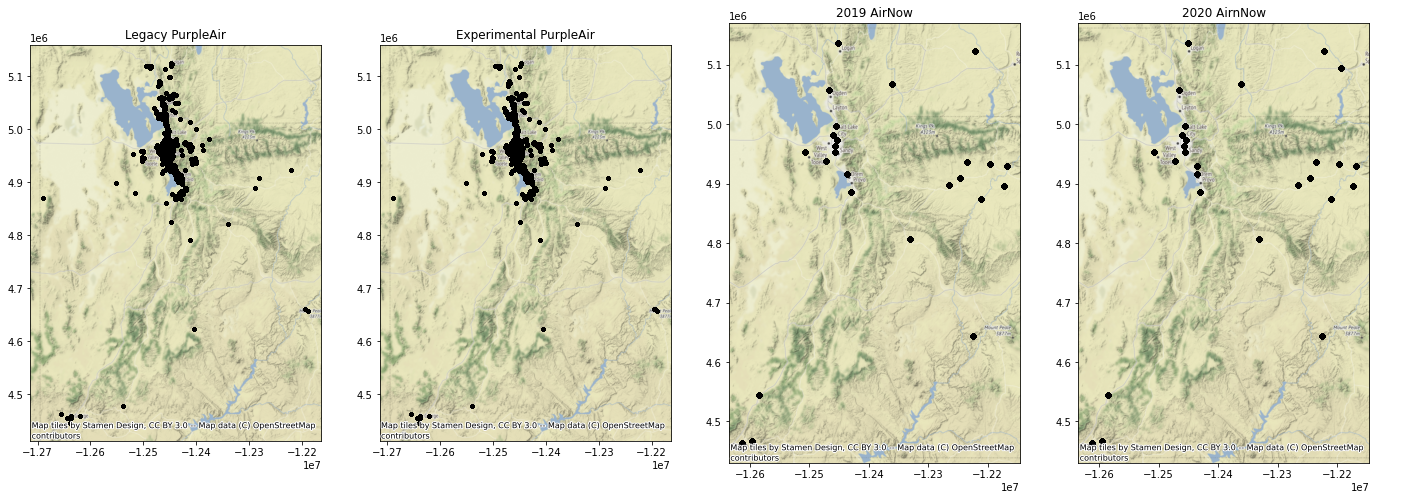

In [10]:
#Plot the sensor locations
f,ax = plt.subplots(1,4,figsize=(24,12))

#plot the location
ut_leg_gdf.plot(ax = ax[0],color = 'k',markersize = 10,marker='o')
ax[0].set_title('Legacy PurpleAir')
ctx.add_basemap(ax[0])

ut_exp_gdf.plot(ax = ax[1],color = 'k',markersize = 10,marker='o')
ax[1].set_title('Experimental PurpleAir')
ctx.add_basemap(ax[1])

airnow_2019_gdf.plot(ax = ax[2],color = 'k',markersize = 20,marker='o')
ax[2].set_title('2019 AirNow')
ctx.add_basemap(ax[2])

airnow_gdf.plot(ax = ax[3],color = 'k',markersize = 20,marker='o')
ax[3].set_title('2020 AirnNow')
ctx.add_basemap(ax[3])

In [11]:
#What are the data dimensions: 
print("The legacy data is of shape {0} x {1}".format(ut_leg_df.shape[0],ut_leg_df.shape[1]))
print("The experimental data is of shape {0} x {1}".format(ut_exp_df.shape[0],ut_exp_df.shape[1]))
print("The 2019 airflow data is of shape {0} x {1}".format(airnow_2019_df.shape[0],airnow_2019_df.shape[1]))
print("The 2020 airflow data is of shape {0} x {1}".format(airnow_df.shape[0],airnow_df.shape[1]))

The legacy data is of shape 173016 x 31
The experimental data is of shape 87936 x 38
The 2019 airflow data is of shape 6760 x 14
The 2020 airflow data is of shape 7064 x 14


In [12]:
#How many sensors are registered:
print("There are {0} legacy sensors".format(len(ut_leg_df['ID'].drop_duplicates())))
print("There are {0} experimental sensors".format(len(ut_exp_df['ID'].drop_duplicates())))
print("There were {0} airnow (EPA) sensors in 2019".format(len(airnow_2019_df['Category'].drop_duplicates())))
print("There are {0} airnow (EPA) sensors in 2020".format(len(airnow_df['Category'].drop_duplicates())))

There are 1030 legacy sensors
There are 524 experimental sensors
There were 25 airnow (EPA) sensors in 2019
There are 27 airnow (EPA) sensors in 2020


In [13]:
#What are the minimum and maximum dates of the data
print("Legacy Dates: Min = {0} Max = {1}".format(ut_leg_gdf['Time'].min(),ut_leg_gdf['Time'].max()))
print("Experimental Dates: Min = {0} Max = {1}".format(ut_exp_gdf['Time'].min(),ut_exp_gdf['Time'].max()))
print("2019 Airnow Dates: Min = {0} Max = {1}".format(airnow_2019_gdf['Time'].min(),airnow_2019_gdf['Time'].max()))
print("2020 Airnow Dates: Min = {0} Max = {1}".format(airnow_gdf['Time'].min(),airnow_gdf['Time'].max()))


Legacy Dates: Min = 2020-04-07 05:00:00-06:00 Max = 2020-04-14 05:00:00-06:00
Experimental Dates: Min = 2020-04-07 05:02:00-06:00 Max = 2020-04-14 05:00:00-06:00
2019 Airnow Dates: Min = 2019-04-07 05:00:00-06:00 Max = 2019-04-14 05:00:00-06:00
2020 Airnow Dates: Min = 2020-04-07 05:00:00-06:00 Max = 2020-04-14 05:00:00-06:00


**Conclusions**
1. The number of sensors for both PurpleAir and Airnow is consistent with the online postings.
2. The minimum and maximum dates all appear to the same. There is some lag in the experimental collection, due to the nature of the query.
3. The data shapes match the number of columns expressed on the website. 

# Focus: PM2.5 Data

For the purposes of this assignment, we will focus on measures of PM2.5. While the experimental data is interesting, there is no way to validate the measures as the Airnow data does not contain pm's of other size. Thus any analysis may become arbitrary. 

### Cleaning the Data

1. Airnow data requires no conversion, all numbers are expressed as floats or integers. 
2. The Purpleair PM2.5 measures need to be adjusted to floats for analysis. 
3. The Airnow concentration data appears to have no extreme measurements and requires no cleaning.
4. The purpleair data has extreme points. We will limit the maximum recorded value to 100 as the maximum of the Airnow values capped at approximately 57.  

In [14]:
#Adjust the data types
ut_leg_gdf['PM2_5Value'] = ut_leg_gdf['PM2_5Value'].astype('float64')
ut_leg_gdf = ut_leg_gdf.rename(columns = {'PM2_5Value':'PM25'})

#Are the values reasonable? 
print('PurpleAir Data Description: ')
print(ut_leg_gdf['PM25'].describe())

print('\nAirnow 2019 Data Description: ')
print(airnow_2019_gdf['Concentration'].describe())

print('\nAirnow 2020 Data Description: ')
print(airnow_gdf['Concentration'].describe())

PurpleAir Data Description: 
count    163079.00000
mean         24.12604
std         316.71628
min           0.00000
25%           0.39000
50%           1.11000
75%           2.41000
max        6147.83000
Name: PM25, dtype: float64

Airnow 2019 Data Description: 
count    6760.000000
mean       24.509334
std        18.572040
min         0.000000
25%         2.900000
50%        31.000000
75%        41.000000
max        55.000000
Name: Concentration, dtype: float64

Airnow 2020 Data Description: 
count    7064.000000
mean       24.530110
std        18.407957
min         0.600000
25%         4.000000
50%        29.000000
75%        42.000000
max        57.000000
Name: Concentration, dtype: float64


In [15]:
#Within the 2020 period of time, the air quality was very good. Let's remove any sensors reading a PM2.5 value
#above 100

#How many readings have high pm25
print('{0} of the PM2.5 readings are above 100'.format(ut_leg_gdf[ut_leg_gdf['PM25']>100].shape[0]))

#So we can remove these sensor readings losing any data regarding the other particulates so lets do that
ut_leg_gdf['PM25'] = ut_leg_gdf['PM25'].fillna(-100)
ut_leg_gdf = ut_leg_gdf[(ut_leg_gdf['PM25']<100)]

print("The new purple data is of shape {0} x {1}".format(ut_leg_gdf.shape[0],ut_leg_gdf.shape[1]))
print("There are {0} total sensors".format(len(ut_leg_gdf['ID'].drop_duplicates())))
print("All Purple Dates: Min = {0} Max = {1}".format(ut_leg_gdf['Time'].min(),ut_leg_gdf['Time'].max()))

935 of the PM2.5 readings are above 100
The new purple data is of shape 172081 x 31
There are 1026 total sensors
All Purple Dates: Min = 2020-04-07 05:00:00-06:00 Max = 2020-04-14 05:00:00-06:00


### Filling Missing Values

Herein we examine and fill missing values within both the Airnow and PurpleAir Data

In [16]:
#Let's refill those PM values with Nans
ut_leg_gdf['PM25'] = ut_leg_gdf['PM25'].replace(-100,np.NaN)

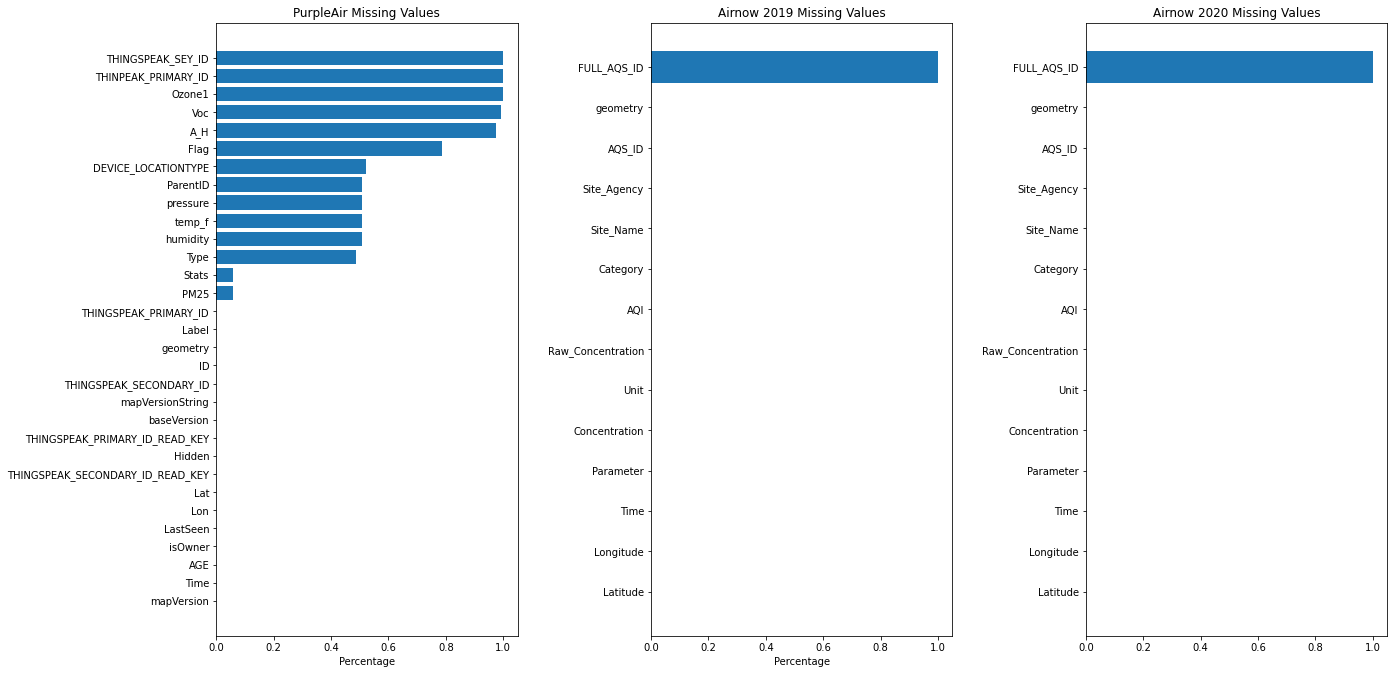

In [17]:
#Let's take a look at the percentage of missing values
purp_na = ut_leg_gdf.isna().sum().sort_values()/ut_leg_gdf.shape[0]
air19_na = airnow_2019_gdf.isna().sum().sort_values()/airnow_2019_gdf.shape[0]
air20_na = airnow_gdf.isna().sum().sort_values()/airnow_gdf.shape[0]

f,ax = plt.subplots(1,3,figsize=(20,10))
ax[0].barh(purp_na.index,purp_na)
ax[0].set_xlabel('Percentage')
ax[0].set_title('PurpleAir Missing Values')

ax[1].barh(air19_na.index,air19_na)
ax[1].set_xlabel('Percentage')
ax[1].set_title('Airnow 2019 Missing Values')

ax[2].barh(air20_na.index,air20_na)
ax[2].set_title('Airnow 2020 Missing Values')

f.tight_layout(pad=3.0)

**Conclusion**
1. PurpleAir
    1. PM25 is missing under 20% of values. Let's fill these values with a nearest geographic neighbor method. 
    2. Pressure, humidity and temperature have are missing under 50% of values. As such, let's fill these with the same nearest geographic neighbor (non-na)
    3. While interesting, ozone and VOC contain too many missing values to be useful.
2. AirNow
    1. Both 2019 and 2020  contain missing values within the full AQS ID column. No filling necessary here. 

#### Filling PurpleAir PM2.5 Values

In [18]:
#THE FOLLOWING TWO CELLS TAKE QUITE A LONG TIME TO RUN AS THE ALGORITHM IS INEFFICIENT. PLEASE LOAD THE DATA 
#INSTEAD TO AVOID WAITING AN EXCESS AMOUNT OF TIME. PLEASE SKIP TO THE HEADER CHECKPOINT

purp_df_full = pd.read_csv('purp_df_full.csv')
purp_df_full.head(3)

/home/boogie2/anaconda3/envs/purp_air/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5,21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,mapVersion,baseVersion,mapVersionString,ID,Label,DEVICE_LOCATIONTYPE,THINGSPEAK_PRIMARY_ID,THINGSPEAK_PRIMARY_ID_READ_KEY,THINGSPEAK_SECONDARY_ID,THINGSPEAK_SECONDARY_ID_READ_KEY,...,Stats,ParentID,Flag,A_H,Voc,Ozone1,Time,THINGSPEAK_SEY_ID,THINPEAK_PRIMARY_ID,point
0,0.4,7,NaN,10808,1-800 Contacts,outside,496465,NJQEPVB0BHDCQKXA,496466,68WPXUEO026F8BB9,...,"{""v"":0.6,""v1"":0.97,""v2"":0.96,""v3"":1.01,""v4"":1....",NaN,NaN,NaN,NaN,NaN,2020-04-07 05:00:00-06:00,NaN,NaN,"(40.507315999999996, -111.899188)"
1,0.4,7,NaN,5460,1027 Hollywood,outside,385885,5CPPE62979927J8N,385886,CY94WZ0PXRIG4FP9,...,"{""v"":1.38,""v1"":1.98,""v2"":1.79,""v3"":1.58,""v4"":1...",NaN,1.0,NaN,NaN,NaN,2020-04-07 05:00:00-06:00,NaN,NaN,"(40.727509999999995, -111.861434)"
2,0.4,7,NaN,944,17th St and Kiesel Ave,NaN,214823,MHT4KHJHELTLZSFV,214824,CVKFP4UE93964PPN,...,"{""v"":0.17,""v1"":0.18,""v2"":0.26,""v3"":0.31,""v4"":0...",NaN,NaN,NaN,NaN,NaN,2020-04-07 05:00:00-06:00,NaN,NaN,"(41.237524, -111.971543)"


In [100]:
#Fill in the PM25 data with the closest (from a spatial point of view)
def closest_point(point, points):
    """ Find closest point from a list of points. """
    return points[cdist([point], points).argmin()]

filled_pm25 = ut_leg_gdf[ut_leg_gdf['PM25'].notna()]
missing_pm25 = ut_leg_gdf[ut_leg_gdf['PM25'].isna()]

#Create point entry
filled_pm25['point'] = [(x, y) for x,y in zip(filled_pm25['Lat'], filled_pm25['Lon'])]
missing_pm25['point'] = [(x, y) for x,y in zip(missing_pm25['Lat'], missing_pm25['Lon'])]

#Finds the closest point for all data 
closest_points = [closest_point(x, list(filled_pm25['point'])) for x in missing_pm25['point']]

/home/boogie2/anaconda3/envs/purp_air/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/boogie2/anaconda3/envs/purp_air/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [101]:
#Now we need to utilize the closest points to fill the PM25 value. 
count = 0

#We will loop through all the closest lat/lon points
for index, point in enumerate(closest_points):
    #Similiar represents all "filled" pm values which have that PM2.5 value
    similiar = filled_pm25[filled_pm25['point'] == point]
    count +=1
    
    #We try to fill based upon an exact time match. Occasionally this fails
    try:
        most_sim = similiar[similiar['Time'] == missing_pm25['Time'].iloc[index]]
        missing_pm25['PM25'].iloc[index] = most_sim['PM25'].iloc[0]
    except:
        print("error with index " + str(index))
    
    #For visualization: 
    if count % 1000 == 0:
        print(count)
        
#We find those values still missing and fill with the average PM25 value
for idx in missing_pm25['PM25'][missing_pm25['PM25'].isna()].index:
    missing_pm25['PM25'].loc[idx] = missing_pm25['PM25'].mean()
    
#PM25 is filled!
purp_df_fill = filled_pm25.append(missing_pm25)

#These calculations take time. For ease of use, saving this so we can preload this data without waiting.
#purp_df_fill.drop(columns = 'geometry').to_csv('purp_df_fill.csv',index = False)

/home/boogie2/anaconda3/envs/purp_air/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/boogie2/anaconda3/envs/purp_air/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


error with index 542
error with index 576
error with index 634
error with index 667
1000
error with index 1769
error with index 1827
error with index 1876
error with index 1885
error with index 1934
error with index 1993
2000
error with index 2002
error with index 2052
error with index 2061
3000
error with index 3120
error with index 3187
error with index 3246
error with index 3297
error with index 3680
error with index 3739
4000
5000
error with index 5213
error with index 5272
error with index 5946
6000
error with index 6005
error with index 6498
7000
error with index 7363
error with index 7525
error with index 7584
8000
error with index 8011
error with index 8070
error with index 8699
error with index 8757
error with index 8871
9000


#### Filling PurpleAir pressure, humidity and temperature

What we know:  

1. Those sensors which are missing temperature, pressure and humidity are missing them for the entire 7 day period of time. 
2. This means that it will be impossible to use some sort of mean fill, instead we will copy in the values based upon the closest sensor. 

In [72]:
#We will operate on the assumption that if missing temperature, the other values are missing as well
#partially validated this assumption when exploring the missing values
def closest_point(point, points):
    """ Find closest point from a list of points. """
    return points[cdist([point], points).argmin()]

filled = purp_df_fill[purp_df_fill['temp_f'].notna()]
missing = purp_df_fill[purp_df_fill['temp_f'].isna()]

#Create point entry
filled['point'] = [(x, y) for x,y in zip(filled['Lat'], filled['Lon'])]
missing['point'] = [(x, y) for x,y in zip(missing['Lat'], missing['Lon'])]

temp_fill = filled['point'].drop_duplicates()
temp_miss = missing['point'].drop_duplicates()
#Finds the closest point for all data 
closest_points = [closest_point(x, list(temp_fill)) for x in temp_miss]

/home/boogie2/anaconda3/envs/purp_air/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/boogie2/anaconda3/envs/purp_air/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [74]:
filler = []
temp_miss = temp_miss.reset_index()
for idx in range(missing.shape[0]):
    miss_point = missing['point'].iloc[idx]
    idx_miss = temp_miss[temp_miss['point'] == miss_point].index[0]
    filler.append(closest_points[int(idx_miss)])

In [84]:
#This is the same process as above, except utilizing 
count = 0
for index, point in enumerate(filler):
    #This collects the sensors with most similiar location
    similiar = filled[filled['point'] == point]
    count +=1
    
    try:
        most_sim = similiar[similiar['Time']== missing['Time'].iloc[index]]
        missing['temp_f'].iloc[index] = most_sim['temp_f'].iloc[0]
        missing['humidity'].iloc[index] = most_sim['humidity'].iloc[0]
        missing['pressure'].iloc[index] = most_sim['pressure'].iloc[0]
    except:
        print("error with index " + str(index))
        
    if count % 1000 == 0:
        print(count)
        
#We find those values still missing and fill with the average value. 
for idx in missing['temp_f'][missing['temp_f'].isna()].index:
    missing['temp_f'].loc[idx] = missing['temp_f'].mean()
    
for idx in missing['pressure'][missing['pressure'].isna()].index:
    missing['pressure'].loc[idx] = filled['pressure'].mean()
    
for idx in missing['humidity'][missing['humidity'].isna()].index:
    missing['humidity'].loc[idx] = filled['humidity'].mean()  
    
#Let's append the values for analysis
purp_df_full = filled.append(missing)

#These calculations take time. For ease of use, saving this so we can preload this data without waiting.
purp_df_full.drop(columns = 'geometry').to_csv('purp_df_full.csv',index = False)

/home/boogie2/anaconda3/envs/purp_air/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/boogie2/anaconda3/envs/purp_air/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/boogie2/anaconda3/envs/purp_air/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pand

error with index 712
error with index 809
error with index 810
1000
2000
3000
4000
5000
6000
7000
error with index 7286
error with index 7745
8000
9000
error with index 9889
error with index 9986
error with index 9987
10000
error with index 10858
11000
error with index 11488
12000
error with index 12408
13000
14000
15000
16000
17000
error with index 17709
error with index 17806
error with index 17807
18000
19000
error with index 19087
error with index 19184
error with index 19185
error with index 19702
20000
error with index 20161
error with index 20620
21000
error with index 21079
error with index 21538
error with index 21571
error with index 21997
22000
error with index 22456
error with index 22915
error with index 22977
23000
error with index 23374
error with index 23833
24000
error with index 24292
error with index 24751
25000
error with index 25209
error with index 25667
26000
error with index 26125
error with index 26126
error with index 26583
27000
error with index 27041
error w

KeyError: "['geometry'] not found in axis"

#### Checkpoint

To avoid running the above filling cells, please start here!

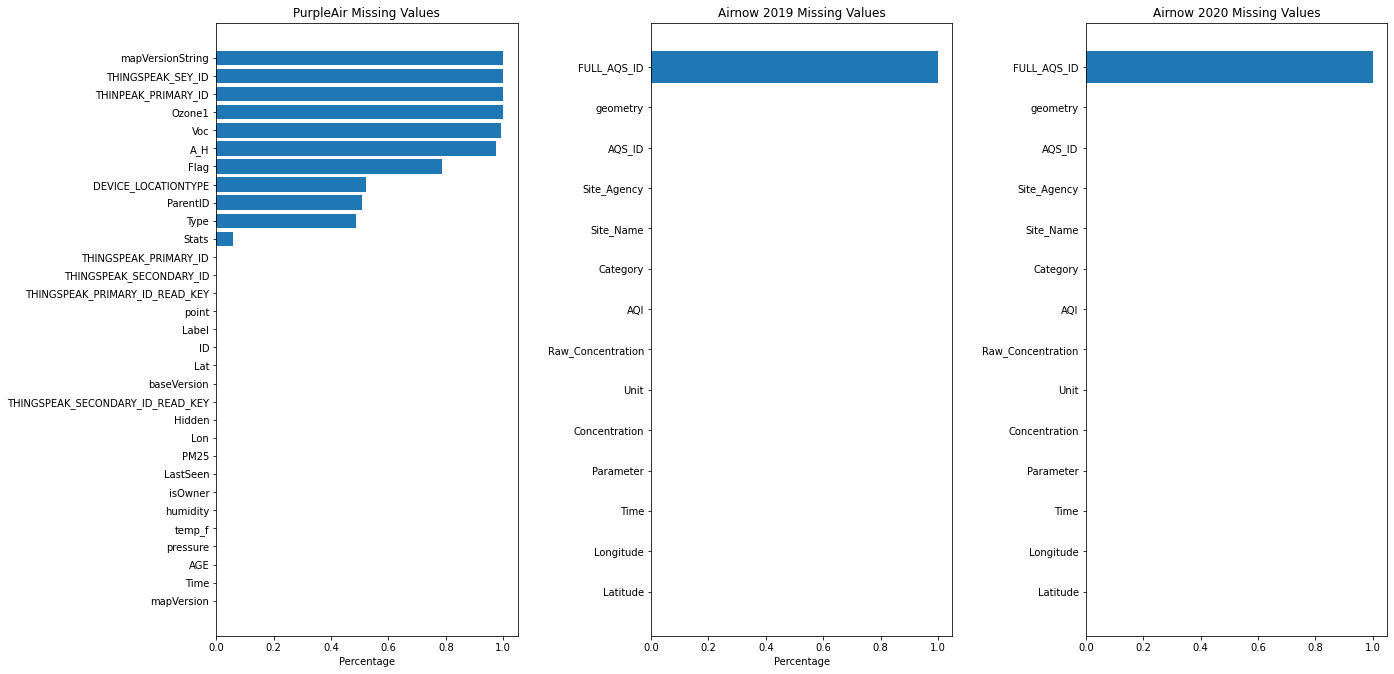

In [19]:
#Visualize the distribution again
#Let's take a look at the percentage of missing values
purp_na = purp_df_full.isna().sum().sort_values()/purp_df_full.shape[0]
air19_na = airnow_2019_gdf.isna().sum().sort_values()/airnow_2019_gdf.shape[0]
air20_na = airnow_gdf.isna().sum().sort_values()/airnow_gdf.shape[0]

f,ax = plt.subplots(1,3,figsize=(20,10))
ax[0].barh(purp_na.index,purp_na)
ax[0].set_xlabel('Percentage')
ax[0].set_title('PurpleAir Missing Values')

ax[1].barh(air19_na.index,air19_na)
ax[1].set_xlabel('Percentage')
ax[1].set_title('Airnow 2019 Missing Values')

ax[2].barh(air20_na.index,air20_na)
ax[2].set_title('Airnow 2020 Missing Values')

f.tight_layout(pad=3.0)

**Conclusion** 
1. This filling process was an extensive process. As many pm2.5, temperature, pressure and humidity were filled using the nearest spatial sensor. For several sensors, this did not work as the nearest sensor was only availible after a certain date. Thereafter, the mean value for all sensors was used to fill. 
2. This step of filling introduces some uncertainty into the data. With more time, I would love to try and model the PM2.5 values utilizing the experimental data, to see if better, more personalized measures could be filled for several of these values. 

# Quality Control: Using Airnow 2020 Data to Adjust the Accuracy of the PurpleAir Data

In the research community, the purpleair data is notorious for being inaccurate. Herein, we test this assumption and see if we can use the Airnow sensors to adjust the purpleair sensors. 

In [20]:
#First let's clean up the dataframes a bit: 
purp_df = purp_df_full[['ID','Lat','Lon','Time','Type','PM25','temp_f','pressure','humidity','AGE','point']]
air_20 = airnow_gdf[airnow_gdf['Parameter'] == 'PM2.5'][['AQS_ID','Category','Concentration','Time',
                                                         'Unit','Latitude','Longitude','geometry']]
air_19 = airnow_2019_gdf[airnow_2019_gdf['Parameter'] == 'PM2.5'][['AQS_ID','Category','Concentration','Time',
                                                         'Unit','Latitude','Longitude','geometry']]

#Let's find where the sensors overlap (if any)
air_20['point'] = [(x, y) for x,y in zip(air_20['Latitude'], air_20['Longitude'])]

pd.merge(purp_df, air_20, how='inner', on=['point']) 

,ID,Lat,Lon,Time_x,Type,PM25,temp_f,pressure,humidity,AGE,point,AQS_ID,Category,Concentration,Time_y,Unit,Latitude,Longitude,geometry


**Conclusion:** 
1. There are no overlapping points!
2. In order to compare the sensors, we must use a spatial aggregation. The finest level posted by the Utah level government is zipcodes from the Utah Mapping Portal (https://gis.utah.gov/)

In [21]:
#Aggregating the purp air data: Zip Codes to maintain fidelity of measurements:

#Merge by zipcode:
zips =fiona.open('ZipCodes.gdb')

# Build the GeoDataFrame from Fiona Collection
zips_gdf = gpd.GeoDataFrame.from_features([feature for feature in zips], crs=zips.crs)
# Get the order of the fields in the Fiona Collection; add geometry to the end
columns = list(zips.meta["schema"]["properties"]) + ["geometry"]
# Re-order columns in the correct order
zips_gdf = zips_gdf[columns]
#Recast the mapping environment
zips_gdf = zips_gdf.to_crs({'init': 'epsg:3857'})

/home/boogie2/anaconda3/envs/purp_air/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [22]:
#Cast purple air dataframe as geodataframe
purp_gdf = gpd.GeoDataFrame(purp_df, geometry=gpd.points_from_xy(purp_df.Lon,purp_df.Lat))
purp_gdf.crs = {'init' :'epsg:4326'}
purp_gdf = purp_gdf.to_crs({'init': 'epsg:3857'})

#PurpleAir Spatial Join
zip_spa_joi = gpd.sjoin(purp_gdf, zips_gdf, op= 'within')
purp_zips = zip_spa_joi.groupby(['ZIP5','Time'])['PM25','temp_f','pressure','humidity'].mean()
purp_zips = pd.DataFrame(purp_zips).reset_index()

#Airnow Spatial Join
zip_spa_joi = gpd.sjoin(air_20, zips_gdf, op= 'within')
air20_zips = zip_spa_joi.groupby(['ZIP5','Time'])['Concentration'].mean()
air20_zips = pd.DataFrame(air20_zips).reset_index()

purp_air_zips = pd.merge(purp_zips, air20_zips, how='inner', on=['ZIP5'])

/home/boogie2/anaconda3/envs/purp_air/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/boogie2/anaconda3/envs/purp_air/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


#### Comparing the Average Difference between the Airnow and PurpleAir Measurments

In [23]:
#Simple Statistical Test: is there a difference between the mean concentration between the two?
#How different are the average PM2.5 Concentrations?
print('The average difference for the aggregated hourly mean of pm2.5 between purpleair and airnow is: ' + 
      str(np.abs(purp_air_zips['Concentration'] - purp_air_zips['PM25']).mean()))

print('The standard deviation for the PurpleAir data: ' + str(np.std(purp_air_zips['PM25'])))
print('The standard deviation for the Airnow data: ' + str(np.std(purp_air_zips['Concentration'])))


The average difference for the aggregated hourly mean of pm2.5 between purpleair and airnow is: 2.1635321774440666
The standard deviation for the PurpleAir data: 2.612680200100298
The standard deviation for the Airnow data: 1.2726365938202855


#### Attempting to predict the Airnow values from the PurpleAir Data

In [24]:
#Adjusting the data format for compatability with stats models
first_date = datetime.strptime(purp_air_zips['Time_x'].iloc[0].split('-06')[0], '%Y-%m-%d %H:%M:%S')
purp_air_zips['hours_since_start'] =(purp_air_zips['Time_x'].
                                     apply(lambda x: datetime.strptime(x.split('-06')[0],
                                                                       '%Y-%m-%d %H:%M:%S')) - first_date)/dt.timedelta(hours=1)

#Can we create a basic model to predict the airnow value from the given humidity etc?
model = smf.ols(formula="Concentration ~ ZIP5+PM25+temp_f + pressure + humidity+hours_since_start", data=purp_air_zips)

# Fit the model
regressor = model.fit()

# Print out the model statistics
print(regressor.summary())

                            OLS Regression Results                            
Dep. Variable:          Concentration   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     7590.
Date:                Thu, 23 Apr 2020   Prob (F-statistic):               0.00
Time:                        10:58:14   Log-Likelihood:            -3.8274e+05
No. Observations:              255697   AIC:                         7.655e+05
Df Residuals:                  255683   BIC:                         7.657e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.7876      0.69

**Conclusion**
<br>There is significant error within purpleair data as the mean difference for the overlapping zipcodes is greater than 1 standard deviation of the airnow data. Thus, we can assume these measures are fairly inaccurate. In an attempt to save these data, I tried to model the concentration of the airnow data using the purpleair, time, humidity, temperature and pressure. Unfortunately, this is a poor model capable of explaining only 27% of variance as demonstrated by r-squared value. 

<br>Thus it seems there is not a reasonable way to adjust the purpleair data to be match the values of the EPA sensor data. For the remainder of this notebook, I will perform an analysis utilizing the gathered data, without merging the sources together. 

# PM25 Analysis & Visualization

### Airnow 2019: Daily

In [25]:
sensor_number = airnow_2019_df['AQS_ID'].drop_duplicates()
print('There were a total of {0} Airflow Sensors in Utah in 2019'.format(sensor_number.shape[0]))

There were a total of 25 Airflow Sensors in Utah in 2019


/home/boogie2/anaconda3/envs/purp_air/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


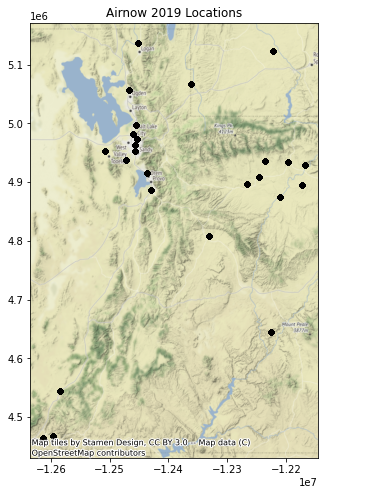

In [117]:
#Examining the Sensor Locations within Utah
airnow_2019_gdf = gpd.GeoDataFrame(airnow_2019_df, geometry=gpd.points_from_xy(airnow_2019_df.Longitude,
                                                                               airnow_2019_df.Latitude))
airnow_2019_gdf.crs = {'init' :'epsg:4326'}
airnow_2019_gdf = airnow_2019_gdf.to_crs({'init': 'epsg:3857'})

# Set up the plotting environment
f,ax = plt.subplots(1,1,figsize=(16,8))

#plot the location
airnow_2019_gdf.plot(ax = ax,color = 'k',markersize = 20,marker='o')
ax.set_title('Airnow 2019 Locations')
ctx.add_basemap(ax)

/home/boogie2/anaconda3/envs/purp_air/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


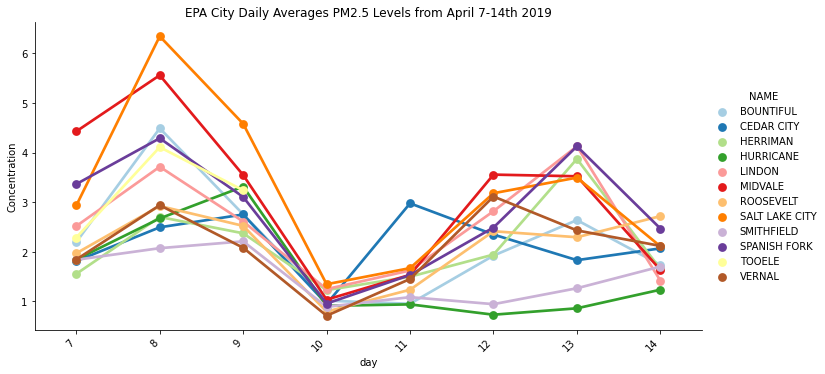

In [105]:
#Calculate the daily averages per sensor of the PM2.5 Data
airnow_2019_pm25 = airnow_2019_gdf[airnow_2019_gdf['Parameter']=='PM2.5']
airnow_2019_pm25['day'] = airnow_2019_pm25['Time'].apply(lambda x:x.day)

#Spatially join the data
air_count_19 = gpd.sjoin(airnow_2019_pm25, zips_gdf, op= 'within')
air_19_count_avgd = pd.DataFrame(air_count_19.groupby(['day','NAME'])['Concentration'].mean()).reset_index()

#Plot the sensors
air_count_2019 = sns.catplot(x='day',
                         y='Concentration',
                         hue='NAME',
                         data=air_19_count_avgd,
                         kind='point',
                         aspect=2,
                         palette = 'Paired')
air_count_2019.set_xticklabels(rotation = 45, ha="right")
air_count_2019.set(title = 'EPA City Daily Averages PM2.5 Levels from April 7-14th 2019')

### Airnow 2020: Daily

In [106]:
sensor_number = airnow_df['AQS_ID'].drop_duplicates()
print('There are a total of {0} Airflow Sensors in Utah in 2020'.format(sensor_number.shape[0]))

There are a total of 27 Airflow Sensors in Utah in 2020


/home/boogie2/anaconda3/envs/purp_air/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


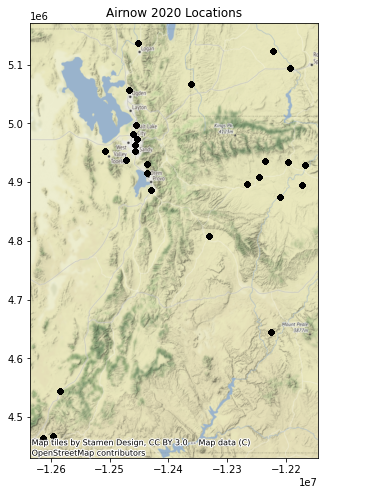

In [107]:
#Convert to a geodataframe and plot
airnow_gdf = gpd.GeoDataFrame(airnow_df, geometry=gpd.points_from_xy(airnow_df.Longitude,
                                                                               airnow_df.Latitude))
airnow_gdf.crs = {'init' :'epsg:4326'}
airnow_gdf = airnow_gdf.to_crs({'init': 'epsg:3857'})

# Set up the plotting environment
f,ax = plt.subplots(1,1,figsize=(16,8))

#plot the location
airnow_gdf.plot(ax = ax,color = 'k',markersize = 20,marker='o')
ax.set_title('Airnow 2020 Locations')
#ax[1].set_xlim(-1.249e7, -1.242e7)
#ax[1].set_ylim(4910000, 4960000)
ctx.add_basemap(ax)

In [108]:
air_count_20['NAME'].drop_duplicates()

0          HURRICANE
2             VIRGIN
3         CEDAR CITY
5             TOOELE
7           HERRIMAN
9              OGDEN
10    SALT LAKE CITY
13           MIDVALE
15         BOUNTIFUL
19        SMITHFIELD
20            LINDON
22     AMERICAN FORK
23      SPANISH FORK
27             PRICE
28          DUCHESNE
29         ROOSEVELT
31        WHITEROCKS
32              MOAB
35            VERNAL
42            JENSEN
Name: NAME, dtype: object

/home/boogie2/anaconda3/envs/purp_air/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


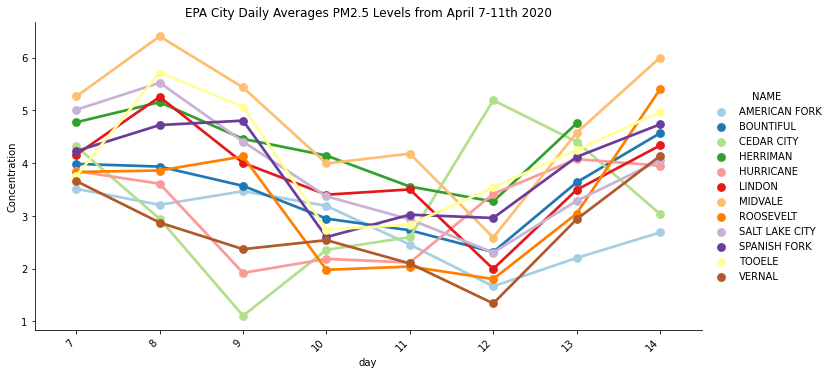

In [109]:
#Try a spatial join:
air_count_20 = gpd.sjoin(airnow_gdf, zips_gdf, op= 'within')

#Grab the PM2.5 Data 
airnow_2020_pm25 = air_count_20[air_count_20['Parameter']=='PM2.5']
airnow_2020_pm25['day'] = airnow_2020_pm25['Time'].apply(lambda x:x.day)

air_20_count_avgd = pd.DataFrame(airnow_2020_pm25.groupby(['day','NAME'])['Concentration'].mean()).reset_index()

#Plot the sensors
air_count_2020 = sns.catplot(x='day',
                         y='Concentration',
                         hue='NAME',
                         data=air_20_count_avgd,
                         kind='point',
                         aspect=2,
                         palette = 'Paired')
air_count_2020.set_xticklabels(rotation = 45, ha="right")
air_count_2020.set(title = 'EPA City Daily Averages PM2.5 Levels from April 7-11th 2020')

### Purpleair 2020: Daily

In [110]:
sensor_number = purp_df['ID'].drop_duplicates()
print('There are a total of {0} PurpleAir Sensors in Utah in 2020'.format(sensor_number.shape[0]))

There are a total of 1026 PurpleAir Sensors in Utah in 2020


/home/boogie2/anaconda3/envs/purp_air/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


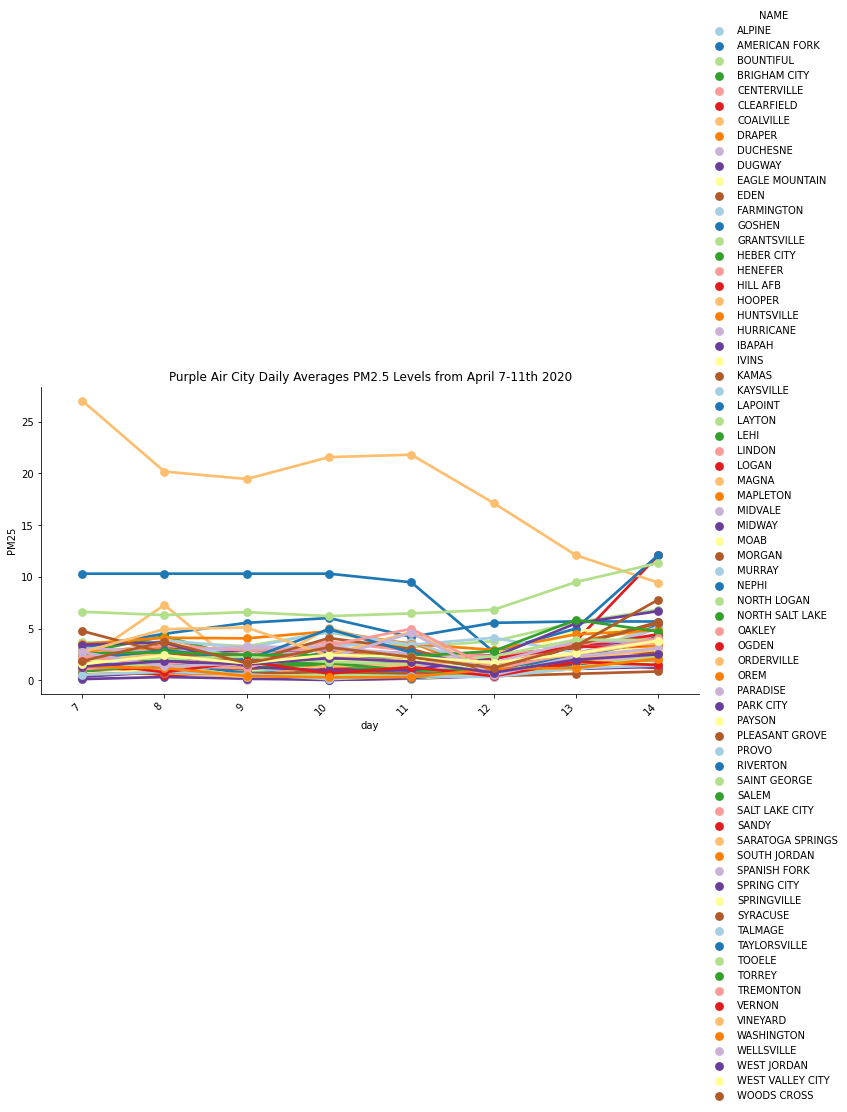

In [111]:
purp_gdf = gpd.GeoDataFrame(purp_df, geometry=gpd.points_from_xy(purp_df.Lon,
                                                                               purp_df.Lat))
purp_gdf.crs = {'init' :'epsg:4326'}
purp_gdf = purp_gdf.to_crs({'init': 'epsg:3857'})

#This is in Mountain Time
purp_gdf['Time'] =purp_gdf['Time'].apply(lambda x: datetime.strptime(x.split('-06')[0],
                                                                       '%Y-%m-%d %H:%M:%S'))

#Try a spatial join:
pair_count_20 = gpd.sjoin(purp_gdf, zips_gdf, op= 'within')

#Grab the PM2.5 Data 
pair_count_20['day'] = pair_count_20['Time'].apply(lambda x:x.day)
pair_20_count_avgd = pd.DataFrame(pair_count_20.groupby(['day','NAME'])['PM25'].mean()).reset_index()

#Plot the sensors
pair_count_2020 = sns.catplot(x='day',
                         y='PM25',
                         hue='NAME',
                         data=pair_20_count_avgd,
                         kind='point',
                         aspect=2,
                         palette = 'Paired')
pair_count_2020.set_xticklabels(rotation = 45, ha="right")
pair_count_2020.set(title = 'Purple Air City Daily Averages PM2.5 Levels from April 7-11th 2020')

In [112]:
#So it seems there might be some bad observed air quality in Coalville: Let's explore that!
pair_20_count_avgd.groupby(['NAME']).mean().sort_values(by= 'PM25')

,day,PM25
NAME,,
PLEASANT GROVE,10.5,0.640802
IBAPAH,10.5,0.662468
TALMAGE,10.5,0.663727
DUGWAY,10.5,0.694731
MOAB,10.5,0.860128
...,...,...
BOUNTIFUL,10.5,4.336097
AMERICAN FORK,10.5,5.037170
NORTH LOGAN,10.5,7.476488


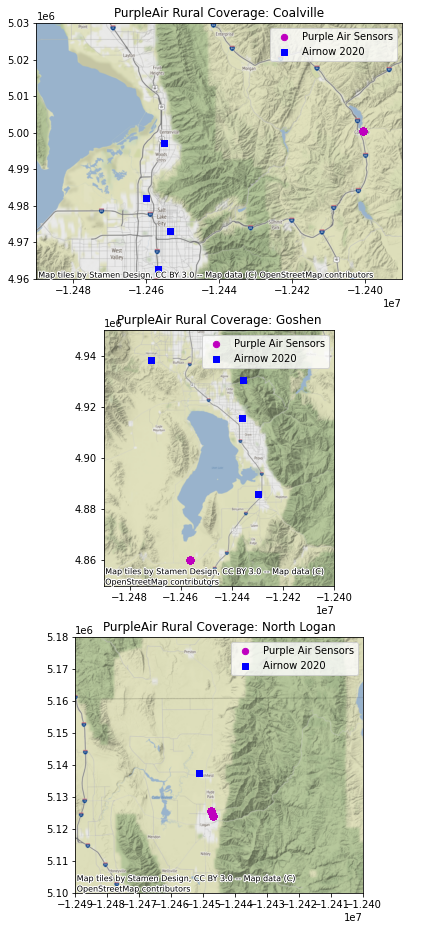

In [113]:
#Let's take a look at where these sensors are
coal= pair_count_20[pair_count_20['NAME']=='COALVILLE']
north_log= pair_count_20[pair_count_20['NAME']=='NORTH LOGAN']
goshen= pair_count_20[pair_count_20['NAME']=='GOSHEN']

# Set up the plotting environment
f,ax = plt.subplots(3,1,figsize=(32,16))

#plot the location
coal.plot(ax = ax[0],color = 'm',markersize = 40,marker='o')
airnow_gdf.plot(ax = ax[0],color = 'b',markersize = 40,marker='s')
ax[0].set_title('PurpleAir Rural Coverage: Coalville')
ax[0].set_xlim(-1.249e7, -1.239e7)
ax[0].set_ylim(4960000, 5030000)
ax[0].legend(['Purple Air Sensors','Airnow 2020 '])
ctx.add_basemap(ax[0])

#plot the location
goshen.plot(ax = ax[1],color = 'm',markersize = 40,marker='o')
airnow_gdf.plot(ax = ax[1],color = 'b',markersize = 40,marker='s')
ax[1].set_title('PurpleAir Rural Coverage: Goshen')
ax[1].set_xlim(-1.249e7, -1.240e7)
ax[1].set_ylim(4850000, 4950000)
ax[1].legend(['Purple Air Sensors','Airnow 2020 '])
ctx.add_basemap(ax[1])

#plot the location
north_log.plot(ax = ax[2],color = 'm',markersize = 40,marker='o')
airnow_gdf.plot(ax = ax[2],color = 'b',markersize = 40,marker='s')
ax[2].set_title('PurpleAir Rural Coverage: North Logan')
ax[2].set_xlim(-1.249e7, -1.240e7)
ax[2].set_ylim(5100000, 5180000)
ax[2].legend(['Purple Air Sensors','Airnow 2020 '])
ctx.add_basemap(ax[2])

**Conclusion**
<br>
So the increased coverage of PM2.5 showcases a hotspot during this time in coalville. This is missed by the Airnow data. This showcases an advantage of the purpleair data: more rural coverage! Additionally, it appears the trends between the airnow data and purpleair data are similiar indicating the general trends may be observed within the purple air data although the exact value may not be present. 

## Analysis: Let's Look at the Hourly Trends:

In [114]:
#Need to create a special plotting variable for the time
index = []
count = 0
for times in purp_gdf['Time'].drop_duplicates():
    
    if count%12 == 0:
        index.append(times)
    else:
        index.append('')
    count+=1

### Airnow 2019: Hourly

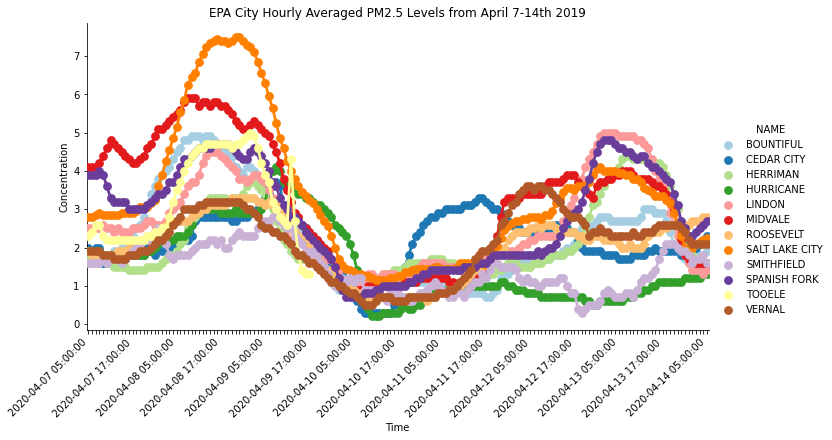

In [115]:
air_19_count_avgh = pd.DataFrame(air_count_19.groupby(['Time','NAME'])['Concentration'].mean()).reset_index()

#Plot the sensors
air_count_2019 = sns.catplot(x='Time',
                         y='Concentration',
                         hue='NAME',
                         data=air_19_count_avgh,
                         kind='point',
                         aspect=2,
                         palette = 'Paired')
air_count_2019.set_xticklabels(index,rotation = 45, ha="right")
air_count_2019.set(title = 'EPA City Hourly Averaged PM2.5 Levels from April 7-14th 2019')

### Airnow 2020: Hourly

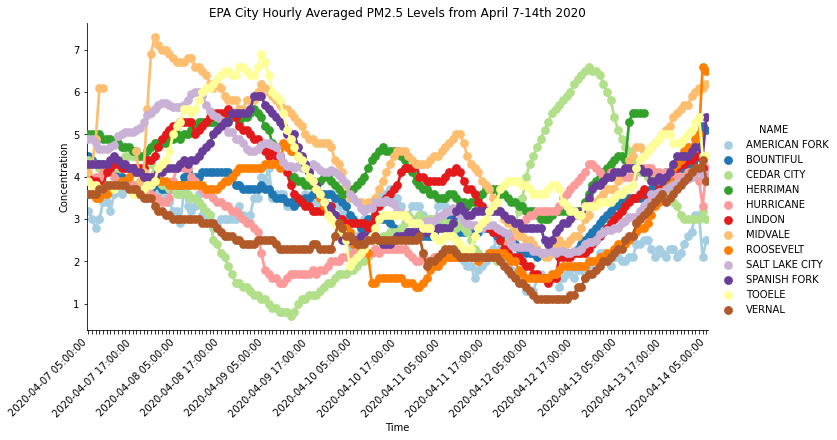

In [116]:
air_20_count_avgh = pd.DataFrame(airnow_2020_pm25.groupby(['Time','NAME'])['Concentration'].mean()).reset_index()

#Plot the sensors
air_count_2020 = sns.catplot(x='Time',
                         y='Concentration',
                         hue='NAME',
                         data=air_20_count_avgh,
                         kind='point',
                         aspect=2,
                         palette = 'Paired')
air_count_2020.set_xticklabels(index,rotation = 45, ha="right")
air_count_2020.set(title = 'EPA City Hourly Averaged PM2.5 Levels from April 7-14th 2020')

### Purpleair 2020: Hourly

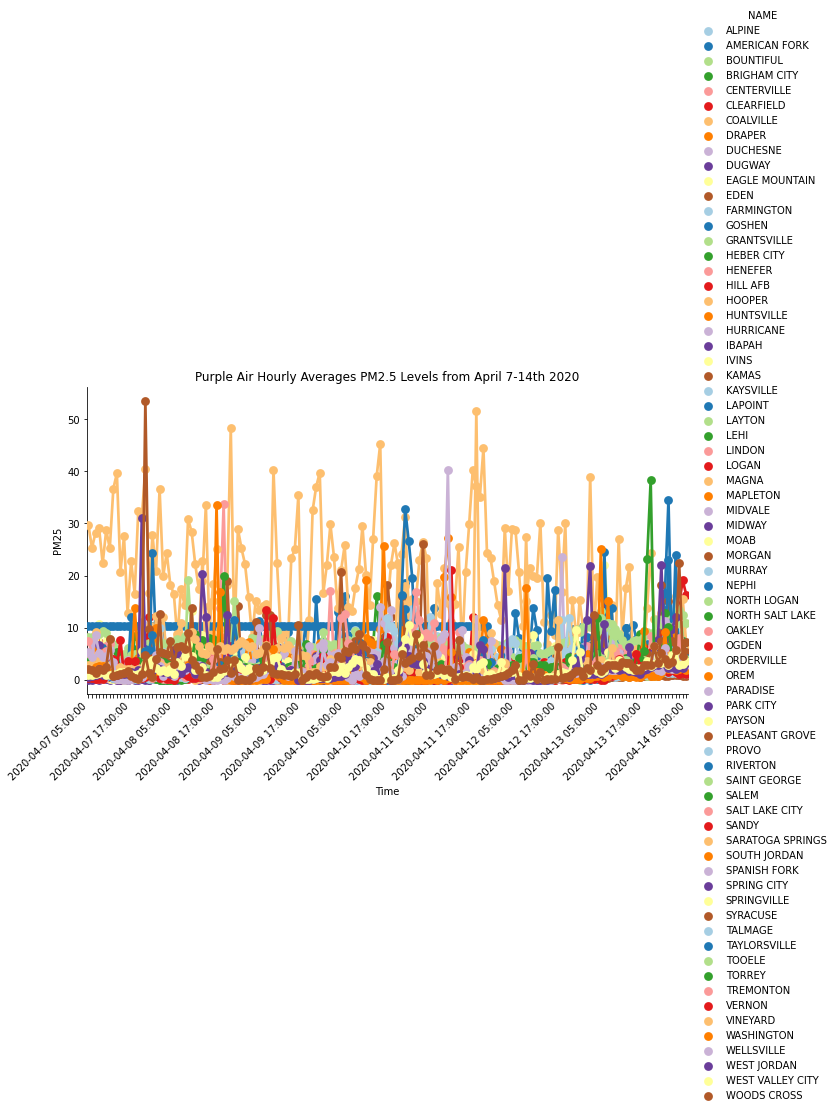

In [41]:
pair_20_count_avgh = pd.DataFrame(pair_count_20.groupby(['Time','NAME'])['PM25'].mean()).reset_index()

#Plot the sensors
pair_count_2020 = sns.catplot(x='Time',
                         y='PM25',
                         hue='NAME',
                         data=pair_20_count_avgh,
                         kind='point',
                         aspect=2,
                         palette = 'Paired')
pair_count_2020.set_xticklabels(index,rotation = 45, ha="right")
pair_count_2020.set(title = 'Purple Air Hourly Averages PM2.5 Levels from April 7-14th 2020')

**Conclusion** 
1. The hourly measurments tell a much more noisy story with the data. Examination of the Airnow data showcases fairly smooth curves over the week-long period. In comparison, the PurpleAir data has much more noise, perhaps a direct result of cyclical trends. If this is the more "true" version of the data it appears there may be some smoothing or post-processing occuring with the EPA data. 
2. In simple, it appears the average PM25 is similiar between 2019 and 2020 with no daily average spiking above 7 for the Airnow data. 

# Answering the Question: How do particulate matter levels change in SLC?

Let's examine the PM25 levels in SLC in 2020 and 2019 by both Airnow and PurpleAir Data

### Airnow 2019: Salt Lake City

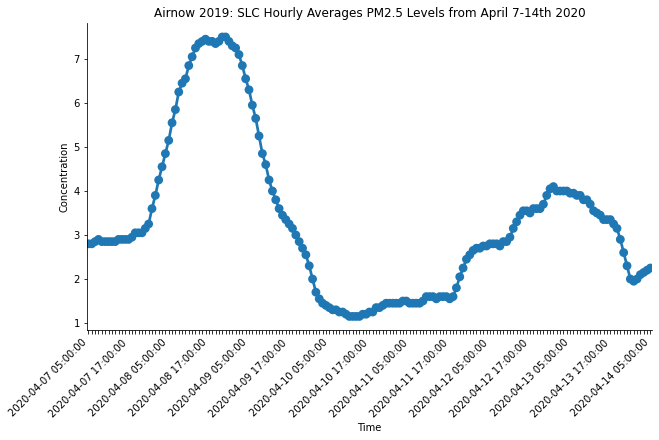

Airnow 2019 Measured Salt Lake City Data Description
       Concentration
count     169.000000
mean        3.331065
std         1.804788
min         1.150000
25%         1.800000
50%         2.900000
75%         3.950000
max         7.500000


In [42]:
airnow_slc19 = air_19_count_avgh[air_19_count_avgh['NAME']=='SALT LAKE CITY']

#Plot the sensors
slc_airnow19= sns.catplot(x='Time',
                         y='Concentration',
                         data=airnow_slc19,
                         kind='point',
                         aspect=2)
slc_airnow19.set_xticklabels(index,rotation = 45, ha="right")
slc_airnow19.set(title = 'Airnow 2019: SLC Hourly Averages PM2.5 Levels from April 7-14th 2020')

plt.show()
print('Airnow 2019 Measured Salt Lake City Data Description')
print(airnow_slc19.describe())

### Airnow 2020: Salt Lake City

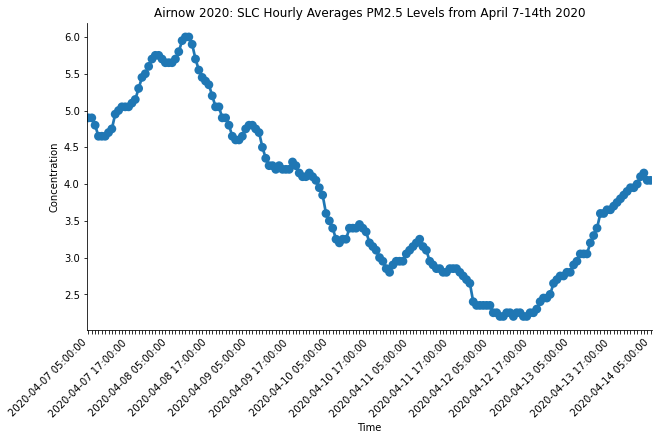

Airnow 2020 Measured Salt Lake City Data Description
       Concentration
count     169.000000
mean        3.805030
std         1.105124
min         2.200000
25%         2.850000
50%         3.650000
75%         4.750000
max         6.000000


In [43]:
airnow_slc = air_20_count_avgh[air_20_count_avgh['NAME']=='SALT LAKE CITY']

#Plot the sensors
slc_airnow= sns.catplot(x='Time',
                         y='Concentration',
                         data=airnow_slc,
                         kind='point',
                         aspect=2)
slc_airnow.set_xticklabels(index,rotation = 45, ha="right")
slc_airnow.set(title = 'Airnow 2020: SLC Hourly Averages PM2.5 Levels from April 7-14th 2020')

plt.show()
print('Airnow 2020 Measured Salt Lake City Data Description')
print(airnow_slc.describe())

### PurpleAir 2020: Salt Lake City

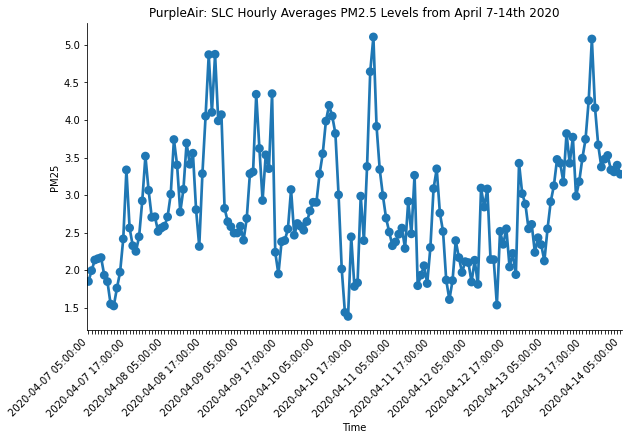

PurpleAir Measured Salt Lake City Data Description
             PM25
count  169.000000
mean     2.835158
std      0.769754
min      1.386055
25%      2.303368
50%      2.695223
75%      3.350277
max      5.105310


In [44]:
slc_avg = pair_20_count_avgh[pair_20_count_avgh['NAME']=='SALT LAKE CITY']

#Plot the sensors
slc_purp= sns.catplot(x='Time',
                         y='PM25',
                         data=slc_avg,
                         kind='point',
                         aspect=2)
slc_purp.set_xticklabels(index,rotation = 45, ha="right")
slc_purp.set(title = 'PurpleAir: SLC Hourly Averages PM2.5 Levels from April 7-14th 2020')

plt.show()
print('PurpleAir Measured Salt Lake City Data Description')
print(slc_avg.describe())

Text(0.5, 1.0, 'PM2.5 Trends in 2020 on April 7th to 14th')

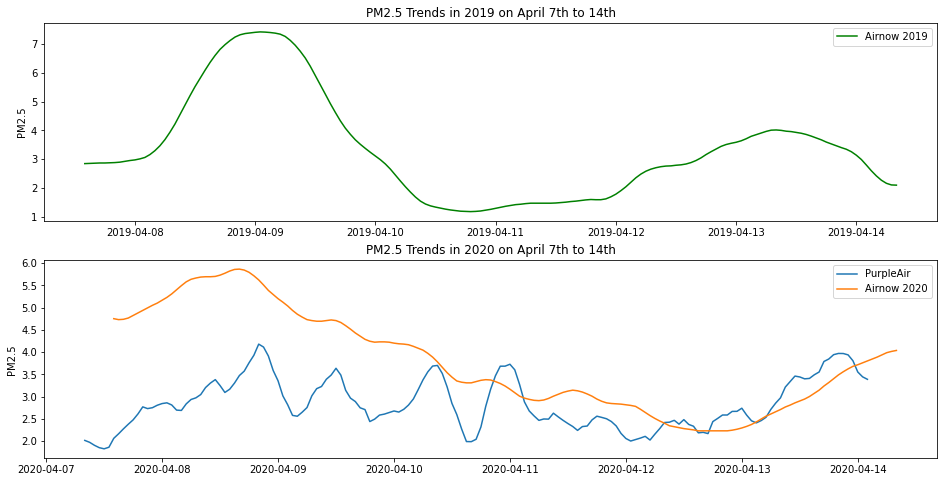

In [54]:
#Comparison of Decompositions:

pair_decomp = sm.tsa.seasonal_decompose(slc_avg.set_index('Time')['PM25'],period=7)
air20_decomp = sm.tsa.seasonal_decompose(airnow_slc.set_index('Time')['Concentration'],period=7)
air19_decomp = sm.tsa.seasonal_decompose(airnow_slc19.set_index('Time')['Concentration'],period=7)

f,ax = plt.subplots(2,1,figsize=(16,8))

ax[0].plot(air19_decomp.trend,'g')
ax[0].legend(['Airnow 2019'])
ax[0].set_ylabel('PM2.5')
ax[0].set_title('PM2.5 Trends in 2019 on April 7th to 14th')

ax[1].plot(pair_decomp.trend)
ax[1].plot(air20_decomp.trend)
ax[1].legend(['PurpleAir','Airnow 2020'])
ax[1].set_ylabel('PM2.5')
ax[1].set_title('PM2.5 Trends in 2020 on April 7th to 14th')


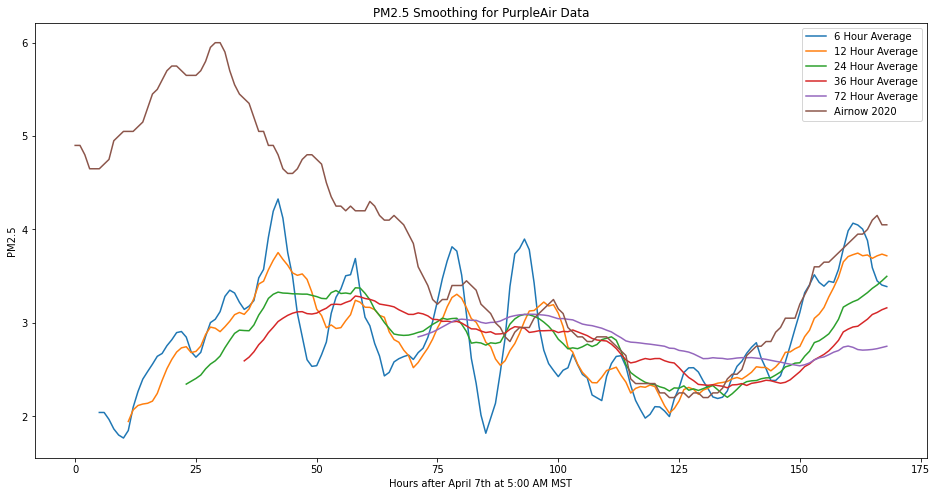

In [55]:
#Can we replicate the smoothing applied by the Airnow Sensors? 
averaged_6 = slc_avg['PM25'].rolling(6).mean().reset_index(drop=True)
averaged_12 = slc_avg['PM25'].rolling(12).mean().reset_index(drop=True)
averaged_24 = slc_avg['PM25'].rolling(24).mean().reset_index(drop=True)
averaged_36 = slc_avg['PM25'].rolling(36).mean().reset_index(drop=True)
averaged_72 = slc_avg['PM25'].rolling(72).mean().reset_index(drop=True)

f,ax = plt.subplots(1,1,figsize=(16,8))
ax.plot(averaged_6)
ax.plot(averaged_12)
ax.plot(averaged_24)
ax.plot(averaged_36)
ax.plot(averaged_72)
ax.plot(airnow_slc['Concentration'].reset_index(drop=True))
ax.set_title('PM2.5 Smoothing for PurpleAir Data')
ax.set_ylabel('PM2.5')
ax.set_xlabel('Hours after April 7th at 5:00 AM MST')
ax.legend(['6 Hour Average',
          '12 Hour Average',
          '24 Hour Average',
          '36 Hour Average',
          '72 Hour Average',
          'Airnow 2020',])

**Conclusions** 
1. Ignoring the spatial variability, the trends only appear slightly related. Both seem to drop lowest around April 12th. 
2. Again, we see that the Airnow data uses smoothing. More variability is captured by the PurpleAir sensors. 
3. The mean of the PM25 for Airnow is slightly higher than the purpleair data (2.83 vs 3.80)
4. The max is higher and the min is lower for the Airnow data. 
5. In 2019, the maximum PM25 reached a higher level (7.5 vs 6) 
6. The average PM25 in 2019 was lower than 2020 by airnow measured data (3.33 vs 3.8)
7. An applied 24 hour filter appears to allow PurpleAir sensor data to recapitulate observations in the Airnow 2020 sensors. 

## Coalville: A Hotspot?

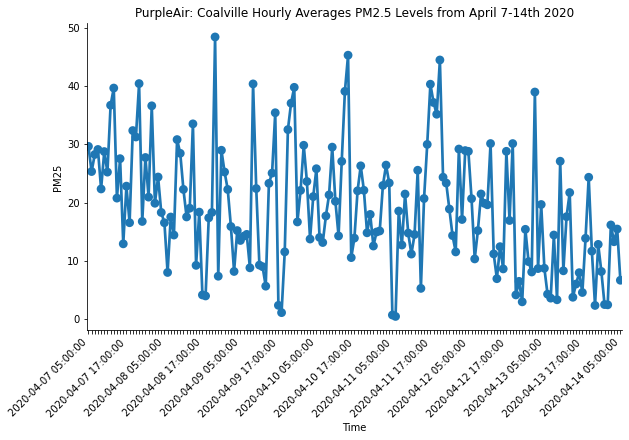

PurpleAir Measured in CoalVille Data Description
             PM25
count  169.000000
mean    19.088639
std     10.447134
min      0.490000
25%     11.550000
50%     17.970000
75%     25.800000
max     48.380000


In [69]:
coalville_avg = pair_20_count_avgh[pair_20_count_avgh['NAME']=='COALVILLE']

#Plot the sensors
coal_purp= sns.catplot(x='Time',
                         y='PM25',
                         data=coalville_avg,
                         kind='point',
                         aspect=2)
coal_purp.set_xticklabels(index,rotation = 45, ha="right")
coal_purp.set(title = 'PurpleAir: Coalville Hourly Averages PM2.5 Levels from April 7-14th 2020')

plt.show()
print('PurpleAir Measured in CoalVille Data Description')
print(coalville_avg.describe())

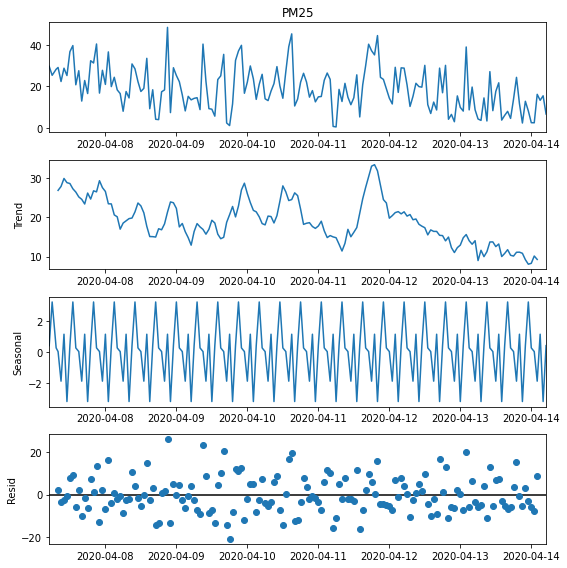

In [71]:
#Let's decompose the Coalville Data
decomposition = sm.tsa.seasonal_decompose(coalville_avg.set_index('Time')['PM25'],period=7)

plt.rcParams["figure.figsize"] = (8,8)
f = decomposition.plot()

## Autocorrelation and Partial AutoCorrelation in the PurpleAir Data

The purpleair data contains some artifacts of the hourly changes throughout the day. Let's explore these artifacts with decomposition and autocorrelation. 

/home/boogie2/anaconda3/envs/purp_air/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


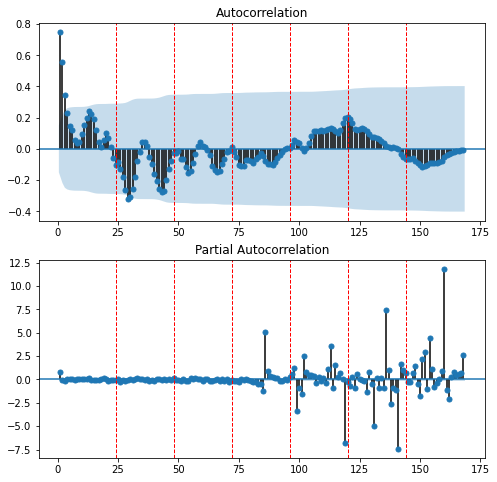

In [47]:
f,axs = plt.subplots(2,1,figsize=(8,8))

fig1 = sm.graphics.tsa.plot_acf(slc_avg['PM25'],zero=False,lags=168,ax=axs[0],alpha=.05)
fig2 = sm.graphics.tsa.plot_pacf(slc_avg['PM25'],zero=False,lags=168,ax=axs[1],alpha=.05)

for ax in axs:
    ax.axvline(24,c='r',ls='--',lw=1)
    ax.axvline(48,c='r',ls='--',lw=1)
    ax.axvline(72,c='r',ls='--',lw=1)
    ax.axvline(96,c='r',ls='--',lw=1)
    ax.axvline(120,c='r',ls='--',lw=1)
    ax.axvline(144,c='r',ls='--',lw=1)
                    


**Conclusions**
<br>Looking at the autocorrelation, it seems that the times closest to the measurement of interest are most correlated. Additionally, there is some correlation with approximately the same time in the next day. Looking at the partial autocorrelation yields slightly different conclusions. Partial correlations favors that days later in the week may be more predictive. Overall, both of these conclusions seem some what arbirtrary as the length of time is too short to be indicative of actual trends. Perhaps with several weeks, these analysis would become more relevant. 

# Prediction: Can we perform any predictions with the collected data? 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Text(0.5, 1.0, 'Observation and Forecast for PM2.5 in Utah')

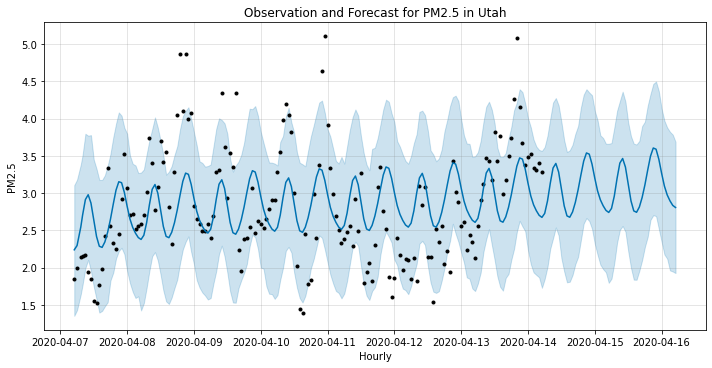

In [68]:
#Rename for prophet analysis:
slc_model = Prophet()
slc_test = slc_avg[['Time','PM25']].rename(columns = {'Time':'ds',
                                                   'PM25':'y'})
slc_model.fit(slc_test)

#Make some predictions about PM25 in SLC
slc_future = slc_model.make_future_dataframe(periods=48,freq='H')
slc_forcast = slc_model.predict(slc_future)

#Let's visualize the Predictions
f,ax = plt.subplots(1,1,figsize=(10,5))
_ = slc_model.plot(slc_forcast,ax=ax)

# Always label your axes
ax.set_xlabel('Hourly')
ax.set_ylabel('PM2.5')
ax.set_title('PurpleAir: Observation and Forecast for PM2.5 in Utah')

/home/boogie2/anaconda3/envs/purp_air/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Text(0.5, 1.0, 'Observation and Forecast for PM2.5 in Utah')

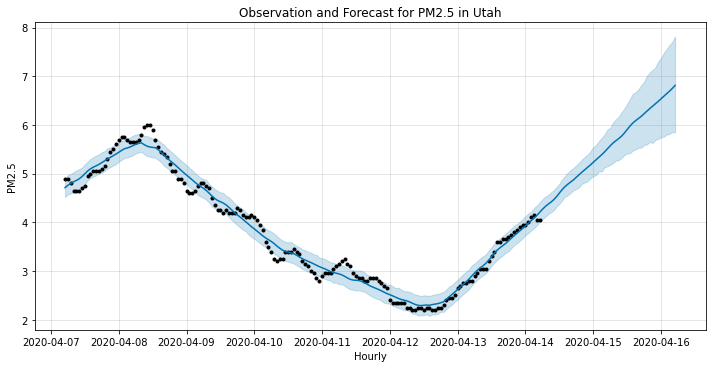

In [67]:
#Rename for prophet analysis:
airnow_slc['Time'] =airnow_slc['Time'].apply(lambda x: datetime.strptime(str(x).split('-06')[0],
                                                                       '%Y-%m-%d %H:%M:%S'))
slc_airnow_model = Prophet()
slc_airnow_test = airnow_slc[['Time','Concentration']].rename(columns = {'Time':'ds',
                                                   'Concentration':'y'})
slc_airnow_model.fit(slc_airnow_test)

#Make some predictions about PM25 in SLC
slc_airnow_future = slc_airnow_model.make_future_dataframe(periods=48,freq='H')
slc_airnow_forcast = slc_airnow_model.predict(slc_airnow_future)

#Let's visualize the Predictions
f,ax = plt.subplots(1,1,figsize=(10,5))
_ = slc_airnow_model.plot(slc_airnow_forcast,ax=ax)

# Always label your axes
ax.set_xlabel('Hourly')
ax.set_ylabel('PM2.5')
ax.set_title('Airnow: Observation and Forecast for PM2.5 in Utah')

# Summary and Conclusion: 

   The Salt Lake City basin is well known as a growing hub of activity with quick access to great skiing and climbing. Unfortunately, the geographic shape of the region leads to “sinkholes” of pollution, particularly particulate matter (PM) and ozone. With reduced wind and precipitation, warm air traps cold air and pollutants in the Salt Lake basin resulting in high particulate concentraions at elevations breathable by those in the city. These trapped toxins are dangerous to human health. Particulate matter 2.5 (PM2.5) is robustly associated with many negative disease outcomes including non-fatal heart attacks, asthma and increased cancer risk. 
    
   Two entities which monitor and predict particulate matter concentrations are the Environmental Protection Agency (EPA) and Purple Air. The EPA tracks air quality in real-time via a network of sensors known as Airnow [1]. These data are available at minute intervals, starting in 1990, via an API on their website. An access token is required to use the API. Getting a token simply requires the entry of email and should be granted to any person with a reasonable question of the data. The spatial coverage is limited as Airnow sensors are typically located near areas with high urban density. Purpleair [2] makes their data available via a .json download from a web portal. No specificity may be made for data dimensions or timeframe. Thus, while these data are available, getting large amounts of data must be performed in real-time. One advantage to the Purpleair data is its widespread spatial coverage, especially in the Salt Lake City basin. Both sensors record PM2.5 measurements, although Purpleair provides additional information on other particulates. Within Utah, the tracking, analysis and forecasting of PM2.5 is critical in protecting public health. Within the research community, air quality is a hot topic for analysis and prediction. While analysis with the EPA data are extensive, hardly any studies have been published with the Purpleair data. Due to temporal limitations posed by collection of Purpleair data, I aimed to explore how particulate matter concentrations change in the week of April 7th to April 14th in the Salt Lake Basin. Furthermore, I wanted to compare if the levels are significantly downregulated with the stay-at-home guidelines imposed by the COVID-19 pandemic. 
    
   In order to collect these data a simple API query and airflow pipeline were utilized. Airnow data was queried at hour intervals from April 7th to April 14th. The documentation of their API was well written, making data collection simple. The Purpleair data collection was a bit more complex as data had to be collected in real-time and downloaded to a local database. In order to perform this regular task, Apache Airflow, an automated scheduler compatible with python, was leveraged. A directed acyclical graph (DAG) was created which ran hourly starting April 7th at 5:00 AM mountain standard time (MST) till April 14th at 5:00AM MST.  Code for this application can be found within the repository under purp_air.py. It was necessary to run this under an Airflow pipeline, as often the link would become temporarily unavailible so redundancy ensured complete collection. After a waiting for a week’s worth of time, all data was collected and ready for exploration. 
   
   Once loaded, cleaning the data quickly became the crux of this project due to computational limitation and inconsistency. The Airnow data was of smaller size as there were fewer total sensors available. The Purpleair legacy data held the greatest amount of information with over 170,000 entries and 1030 sensors. Time zone conversions were necessary to ensure consistency between Airnow and Purpleair data was maintained. As expected, the spatial coverage of Purpleair was much higher than Airnow. Of note, the coverage of Airnow was better than expected, with many more points in the eastern portion of the state. After exploring the experimental measures from Purpleair, a decision was made to focus on PM2.5 data as this contained the most non-null information and had easily accessible documentation. An attempt was made to merge the experimental data with the legacy data but due a <10% overlap between sensor ID’s and locations, this introduced too many null values to be of use. Thus the remainder of the analysis focuses on comparing Airnow 2020, Airnow 2019 and legacy Purpleair 2020 data. 
   
   Visualization of the null values showcased that approximately 6% of the Purpleair data was missing PM2.5 and 45% of other variables of interest such as pressure, temperature and humidity. The Airnow data contained no missing values. In order to fill the Purpleair missing values, an algorithm was created to fill values based upon spatially and temporally most relevant sensor. In simple, values were filled with information from the closest sensor with a time match. Due to the inefficiency of the algorithm created, this process took a large amount of time. After running, several points had to be dealt with by hand as no other sensors of reasonable proximity had data for the desired timepoint. For these values, a simple average based upon the time hour was inserted. This filling step is perhaps the most simplistic and introduces the most bias into the analysis. 
   
   Once missing data was filled, a quality control step was performed to compare the Purpleair measurements to the Airnow measurements within 2020. Initially, an exact comparison was made between the PurpleAir and Airnow sensors to see if an exact comparison could be made. Unfortunately this returned no values. Next, a spatial join was performed to align zip codes and cities with each of the latitude/longitude of the sensors. Mean hourly measurements were created for each of the overlapping zip codes. To compare the sensors, an absolute difference of the value was taken. On average, the Purpleair sensors deviated by 2.16 ug/m3 from the Airnow data. This value was greater than 1 standard deviation of the Airnow data, supporting the inaccuracy of the Purpleair concentrations. In an attempt to align the concentrations of the Airnow and PurpleAir data, a multiple-regression was created with the existing PurpleAir features to predict a given Airnow concentration. Unfortunately, the r-squared of this model was low, ~27%, implying this task was not linearly correlated. As such, a decision was made to examine and compare the data sources independently, acknowledging that trends may be revealed but specific concentrations of Purpleair data were not accurate. 
   
   Next, measurements were spatially aggregated by city and averaged daily. These plots showcase that overall PM2.5 levels in the state of Utah were below 10 for the week of April 7th – 14th for both 2019 and 2020. No noticeable changes are visible based between 2019 and 2020. Comparison of Purpleair and Airnow in 2020 yielded upregulated PM2.5 in Coalville, Goshen and North Logan. These observations were missed by the Airnow monitors due to their limited spatial coverage. Examination of daily trends showcased that Airnow monitors may also smooth their data, as temporal cycles expected of particulate matter were not visible. Purpleair data has more of these cycles, with some evidence of bimodal daily peaks around 9AM and 5PM. Thus, while Airnow data appears to be more accurate, Purpleair data contributes data on rural communities and hourly specificity. When smoothed with a 24 hour rolling filter, the Purpleair data appears to mirror the trends of the Airnow data, although the magnitude of the concentrations are still inaccurate.
   
   A basic prediction was attempted utilizing Facebook’s prophet package. Two models were created, one based upon the Purpleair data and another on the Airnow data. Overall, the Purpleair model seemed to give more accurate predictions as the Airnow model seemed constrained by the limited noise within the data. Neither of these models performs well though as the amount of data is limited and the trends are not representative for future days. More information should be included to improve prediction such as weather and traffic data. 
   
   In total, this exploration showcases the true “wrangling” attitude necessary to explore large, unrefined datasets. Purpleair sensor concentrations should not be considered accurate in comparison to EPA sensors. Yet, these sensors do catch high spatial and temporal variability which may be beneficial in alerting surrounding populations of dangerous air spikes, although the magnitude of the danger may be difficult to quantify. The greatest limitation of these analysis was the lack of data. With an extended period of time, more Purpleair data could be beneficial to researchers and the population as a whole. Assumptions for cleaning the data should be verified and other options, such as recurrent neural networks, for filling data should be explored. Finally, if these data were ever used for predictions, more data should be included and for greater timespan. In total, this project acts as a fantastic initial exploration of a novel data source. While somewhat inaccurate, Purpleair data represents a large repository for fine spatial monitoring of rural and urban particulates in real-time. 

[1] https://docs.airnowapi.org/ 
[2] https://www.purpleair.com/json 
